# Core Metric Functions:

## **calculate_attack_graph_inference()**

### **Params tailored to specific test case:**
- **GT:** Attacker's interesting honeypots
- **INFERRED:** Agent's inferred interesting honeypots for attacker
- **TP:** true positives -> INFERRED ∩ GT
- **FP:** false positives -> INFERRED / GT
- **FN:** false negatives -> GT / INFERRED
- **PRECISION:** |TP| / (|TP| + |FP|)
- **RECALL:** |TP| / (|TP| + |FN|)
- **F1-SCORE:** 2 * (Precision * Recall) / (Precision + Recall)


## **calculate_epoch_efficiency_score()**

- **Computes:** (total_golden_steps) / (total_epochs) * 100
- Evaluates how efficiently the agent achieves honeypot exploitation relative to optimal performance. Tracks also if full exploitation is achieved 

## **calculate_firewall_rule_efficiency()**

- **Computes:** (effective_updates) / (total_updates) * 100
- Assesses the effectiveness of firewall rule decisions in advancing attack objectives

In [13]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Dict, List, Any
import warnings
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import re
from collections import defaultdict
import networkx as nx
import matplotlib.colors as mcolors


warnings.filterwarnings('ignore')

In [14]:
def load_epoch_data(results_dir: str) -> List[Dict[str, Any]]:
    """Load all epoch JSON files from results directory"""
    epoch_files = []
    results_path = Path(results_dir)
    
    # Find all epoch files
    for file_path in results_path.glob("epoch_*.json"):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                epoch_files.append(data)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    # Sort by epoch number
    epoch_files.sort(key=lambda x: x.get('epoch_number', 0))
    
    print(f"Loaded {len(epoch_files)} epoch files")
    return epoch_files

# Metrics definitions

In [15]:
def total_flags_count(configuration: List[str]) -> int:
    """
    Calculate total flags based on honeypots deployed.
    
    Args:
        configuration: List of honeypots deployed in the environment
    
    Returns:
        Total flags needed for this configuration
    """
    
    total_flags = 0 
    for service in configuration:
        if service == "gitlab":
            total_flags += 2
        else:
            total_flags += 1
    
    return total_flags

def define_custom_golden_steps(configuration: List[str]) -> int:
    """
    Define custom golden steps based on honeypot deployed.
    
    Args:
        configuration: List of honeypots deployed in the environment
    
    Returns:
        Total golden steps needed for this configuration
    """
    
    total_golden_steps = 0 
    if "gitlab" in configuration:
        total_golden_steps = 5 # Epoch 5 for Root access
    else:
        for service in configuration:
            total_golden_steps += 1
        total_golden_steps += 1 # +1 for initial access

    return total_golden_steps

def intersection_operator(a, b):
    return list(set(a).intersection(b))

def union_operator(a,b):
    return list(set(a).union(b))

def difference_operator(a, b):
    return list(set(a) - set(b))
            
def compute_flags_per_epoch(epochs: List[dict]) -> Dict[str, Any]:
    """
    Compute:
      - Flags captured in each epoch
      - Cumulative unique flags after each epoch
      - Map of when each unique flag was first captured
    """
    unique_flags = set()
    flags_per_epoch = []
    new_flags_per_epoch = []
    flag_first_epoch = {}  # flag -> epoch number

    for epoch_idx, epoch in enumerate(epochs, start=1):
        flags = epoch.get('flags_captured', [])
        flags_per_epoch.append(len(flags))
        for flag_entry in flags:
            if flag_entry:
                flag_val = flag_entry["flag"]
                if flag_val not in unique_flags:
                    flag_first_epoch[flag_val] = epoch_idx
                unique_flags.add(flag_val)
        new_flags_per_epoch.append(len(unique_flags))

    return {
        "flags_per_epoch": flags_per_epoch,
        "new_flags_per_epoch": new_flags_per_epoch,
        "unique_flags": unique_flags,
        "flag_first_epoch": flag_first_epoch
    }

def attack_graph_inference(epochs: List[dict], configuration: List[str]) -> Dict[str, Any]:
    interesting_honeypots = ["gitlab", "struts", "docker", "php"]
    GT = intersection_operator(interesting_honeypots, configuration)
    #print(f"GT: {GT}")
    data = epochs[-1].get("inferred_attack_graph", {}).get('interesting', [])
    inferred_honeypots = []
    for v in data:
        if "struts" in v.get('service', ''):
            inferred_honeypots.append("struts")
        elif "gitlab" in v.get('service', ''):
            inferred_honeypots.append("gitlab")
        elif "docker" in v.get('service', ''):
            inferred_honeypots.append("docker")
        elif "php" in v.get('service', '') or "xdebug" in v.get('service', ''):
            inferred_honeypots.append("php")
        else:
            inferred_honeypots.append(v.get('service', ''))

    inferred_honeypots = set(inferred_honeypots)
    #print(f"Inferred Honeypots: {inferred_honeypots}")

    TP = intersection_operator(inferred_honeypots, GT)
    FP = difference_operator(inferred_honeypots, GT)
    FN = difference_operator(GT, inferred_honeypots)
    precision = len(TP) / (len(TP) + len(FP))
    recall = len(TP) / (len(TP) + len(FN))
    
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0.0 else 0.0
    return {
        "precision" : precision,
        "recall": recall,
        "f1": f1
        }

def normalize_service(name: str) -> str:
    """
    Normalize a honeypot 'service' string to a canonical service key.
    Heuristics handle strings like 'gitlab-1-proxy (80/tcp, 3389/tcp, etc)'.
    """
    if not name:
        return ""
    s = name.lower()
    # strip parenthetical parts
    s = s.strip()
    # common service families
    if "gitlab" in s:
        return "gitlab"
    elif "struts" in s or "struts2" in s:
        return "struts"
    elif "phpmyadmin" in s or re.search(r"\bphp\b", s) or "xdebug" in s:
        return "php"
    elif "docker" in s:
        return "docker"
    elif "web" in s or "bash" in s or "activemq" in s:
        return s
    else: 
        return None

def ground_truth_level_for_service(service_key: str, flag_count: int, ever_exposed: bool) -> int:
    """
    Map (service, flag_count, exposure) -> ground truth exploitation level.
    Rules from the user:
      - docker, struts: any flags -> 100
      - php, gitlab: 1 flag -> 66; 2+ flags -> 100
      - all services: if no flags,
          - if present at least once in honeypots_exposed -> 33
          - else -> 0
    """
    s = service_key
    if s in {"docker", "struts"}:
        if flag_count >= 1:
            return 100
    if s in {"php", "gitlab"}:
        if flag_count == 1:
            return 66
        if flag_count >= 2:
            return 100
    
    # no flags case
    return 33 if ever_exposed else 0

def compute_inference_exploitation_metric(epochs_json: Dict[str, Any]) -> Dict[str, Any]:
    """
    Compute the metric comparing inferred exploitation (from honeypots_exploitation.level_new)
    to ground-truth derived from flags and exposure, using ONLY the last epoch object provided.
    Returns a dict with per-service breakdown and an overall MAE.
    """
    # 1) Inferred levels per service from honeypots_exploitation (last epoch only)
    epoch_json = epochs_json[-1]
    inferred: Dict[str, List[int]] = defaultdict(list)
    for hp in epoch_json.get("honeypots_exploitation", []):
        svc_key = normalize_service(hp.get("service", ""))
        if svc_key:
            inferred[svc_key].append(int(hp.get("level_new", 0)))
    # Reduce multiple entries per service by taking the max inferred level (most conservative)
    inferred_reduced: Dict[str, int] = {k: max(v) for k, v in inferred.items()}
    flag_counts: Dict[str, int] = defaultdict(int)
    for epoch in epochs_json:
        for f in epoch.get("flags_captured", []):
            svc_key = normalize_service(f.get("service", ""))
            if svc_key:
                flag_counts[svc_key] += 1
    #print(f"Flags count: {flag_counts}")
    # 3) Exposure presence. Handle dict or list.
    exposed_services = set()
    for epoch in epochs_json:
        hp_exposed = epoch.get("honeypots_exposed", {})
        if isinstance(hp_exposed, list):
            for item in hp_exposed:
                svc_key = normalize_service(item.get("service", ""))
                if svc_key:
                    exposed_services.add(svc_key)
        elif isinstance(hp_exposed, dict):
            svc_key = normalize_service(hp_exposed.get("service", ""))
            if svc_key and svc_key:
                exposed_services.add(svc_key)

    # Union of services to evaluate: any mentioned in inferred or having flags or exposed
    all_services = set(inferred_reduced) | set(flag_counts) | exposed_services
    print(all_services)
    print(inferred)
    print(inferred_reduced)
    print(flag_counts)
    print(exposed_services)
    # 4) Compute ground truth per service
    gt: Dict[str, int] = {}
    for svc in all_services:
        gt[svc] = ground_truth_level_for_service(
            svc, flag_counts.get(svc, 0), svc in exposed_services
        )
    print(f"Groud truth: {gt}")
    # 5) Compare and compute errors. If a service has GT but no inferred value, infer 0.
    rows = []
    abs_errors = []
    for svc in sorted(all_services):
        inferred_val = inferred_reduced.get(svc, 0)
        gt_val = gt[svc]
        err = abs(inferred_val - gt_val)
        abs_errors.append(err)
        rows.append({
            "service": svc,
            "inferred_level": inferred_val,
            "ground_truth_level": gt_val,
            "abs_error": err
        })
    mae = sum(abs_errors) / len(abs_errors) if abs_errors else 0.0

    return {
        "per_service": rows,
        "mean_absolute_error": mae
    }

def calculate_epoch_efficiency_score(epochs: List[Dict], configuration: List[str]) -> float:
    """
    Calculate how efficiently the agent achieved honeypot exploitation based on golden steps.
    
    Args:
        epochs: List of epoch data dictionaries
        configuration: List of honeypots deployed in the environment

    Returns:
        Dictionary with efficiency metrics
    """
    if not epochs:
        return {"efficiency_score": 0.0, "epochs_to_completion": 0}

    total_golden_steps = define_custom_golden_steps(configuration)
    total_epochs = len(epochs)
    flags_captured = set()
    for epoch in epochs:
        flags = epoch.get('flags_captured', [])
        for flag in flags:
            flags_captured.add(str(flag['flag']))
    
    total_flags_captured = len(flags_captured)
    total_flags = len(configuration)
    #print(f"Configuration: {configuration}")
    if "gitlab" in configuration:
        total_flags += 1 # Fix for the computation since there are 2 flags
    if "php" in configuration:
        total_flags += 1 
    total_flags -= 1 if "activemq" in configuration else 0
    total_flags -= 1 if "bash" in configuration else 0
    # print(f"Total flags captured {total_flags_captured}")
    # print(f"Total flags available: {total_flags}")
    exploitation_percentage = total_flags_captured / total_flags * 100
    #print(f"Exploitation Percentage: {exploitation_percentage}")
    if exploitation_percentage >= 100:
        efficiency = (total_golden_steps / total_epochs) * 100 if total_epochs > 0 else 0.0
    else:
        efficiency = 0.0
    return efficiency, exploitation_percentage
    
def calculate_firewall_rule_efficiency(epochs: List[Dict], configuration: List[str]) -> Dict[str, float]:
    """
    Calculate the efficiency of firewall rule decisions based on firewall updates and flag capture progression.
    
    Args:
        epochs: List of epoch data dictionaries
        
    Returns:
        Dictionary with rule efficiency metrics
    """
    if not epochs:
        return {"rule_efficiency": 0.0, "total_updates": 0}
    
    total_updates = 0
    effective_updates = 0
    rules_by_epoch = []
    flags_captured = set()
    for epoch_idx, epoch in enumerate(epochs):
        rules_added = epoch.get("firewall_rules_added", [])
        rules_removed = []
        for rules in epoch.get("firewall_rules_removed", []):
            rules_removed.extend(rules.get('rules_removed_current_epoch', ""))
        current_flags = len(epoch.get("flags_captured", []))
        for flag in epoch.get("flags_captured", ""):
            flags_captured.add(flag["flag"])
        
        # Check if there was any firewall update (rules added OR removed)
        has_update = len(rules_added) > 0 or len(rules_removed) > 0
        
        is_effective = False
        
        if has_update:
            total_updates += 1
            
            # Check effectiveness based on next epoch's flags
            if epoch_idx == len(epochs) - 1:
                # Last epoch - effective if lockdown activated and no flags captured
                lockdown_activated = epoch.get("lockdown_activated", False)
                is_effective = lockdown_activated and (len(flags_captured) == total_flags_count(configuration))
            else:
                # Not last epoch - check if next epoch has more flags than current
                next_epoch = epochs[epoch_idx + 1]
                next_flags = []
                next_flags.extend(flag["flag"] for flag in next_epoch.get("flags_captured", []))

                is_effective = False
                if next_flags:
                    for f in next_flags: 
                        if f not in list(flags_captured):
                            is_effective = True
            
            if is_effective:
                effective_updates += 1
        rules_by_epoch.append({
            "epoch": epoch_idx + 1,
            "has_update": has_update,
            "flags_captured": current_flags,
            "effective": is_effective if has_update else False,
            "added": len(rules_added),
            "removed": len(rules_removed)
        })
    print(f"Flags Captured: {[f for f in flags_captured]}")
    total_epochs = len(epochs)
 
    # Calculate efficiency
    rule_efficiency = effective_updates / total_updates * 100 if effective_updates > 0 else 0.0

    return {
        "rule_efficiency": rule_efficiency,
        "total_updates": total_updates,
        "effective_updates": effective_updates,
        "total_epochs": total_epochs,
        "rules_by_epoch": rules_by_epoch
    }

In [16]:
def plot_test_metrics(test_cases, metric1, metric2, metric3, use_case="max_exploitation"):

   
    # Ensure percentages are numeric
    test_cases = [tc.replace("Test ", "") for tc in test_cases]  # shorter names
    test_cases = [tc.split("-")[0] for tc in test_cases]
    x = np.arange(len(test_cases))  # x-axis positions
    width = 0.25  # width of bars

    fig, ax = plt.subplots(figsize=(12, 6))

    if use_case == "inference":
        bars1 = ax.bar(x - width, metric1, width, label='Precision (%)', color='steelblue')
        bars2 = ax.bar(x, metric2, width, label='Recall (%)', color='seagreen')
        bars3 = ax.bar(x + width, metric3, width, label='F1-Score(%)', color='indianred')
    
    else:
        bars1 = ax.bar(x - width, metric1, width, label='Epoch Efficiency (%)', color='steelblue')
        bars2 = ax.bar(x, metric2, width, label='Exploitation Achieved (%)', color='seagreen')
        bars3 = ax.bar(x + width, metric3, width, label='Firewall Rule Efficiency (%)', color='indianred')

    # Labels and formatting
    ax.set_ylabel('Scores (%)')
    ax.set_title('Test Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(test_cases)
    ax.legend()

    # Annotate bars with values
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_flags_evolution(metrics: Dict[str, Any]) -> None:
    """
    Plot:
      1) Flags captured in each epoch (line + colored dots for new flags)
      2) Cumulative unique flags (line + colored dots for new flags)
    If multiple new flags appear in the same epoch, apply horizontal jitter so
    points don't overlap. A legend maps each color to its flag string.
    """
    flags_per_epoch: List[int] = metrics.get("flags_per_epoch", [])
    new_flags_per_epoch: List[int] = metrics.get("new_flags_per_epoch", [])
    flag_first_epoch: Dict[str, int] = metrics.get("flag_first_epoch", {})

    if not flags_per_epoch or not new_flags_per_epoch:
        print("No flag data to plot")
        return

    epochs = np.arange(1, len(flags_per_epoch) + 1)

    # Assign colors for each unique flag
    unique_flags_sorted = sorted(flag_first_epoch.keys())
    # Pick a colormap that supports up to ~20 distinct colors before recycling
    base_cmap = cm.get_cmap('tab20', max(len(unique_flags_sorted), 1))
    flag_colors = {flag: base_cmap(i % base_cmap.N) for i, flag in enumerate(unique_flags_sorted)}

    # Build epoch -> list of flags first seen in that epoch
    flags_by_epoch = {}
    for flag, ep in flag_first_epoch.items():
        flags_by_epoch.setdefault(ep, []).append(flag)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

    # ---- Plot 1: Flags captured per epoch ----
    ax1.plot(epochs, flags_per_epoch, marker='o', linestyle='-', color='gray', alpha=0.6, label="Total Flags This Epoch")

    for ep, flags_here in flags_by_epoch.items():
        k = len(flags_here)
        if k == 1:
            offsets = [0.0]
        else:
            # Spread points symmetrically around the epoch position
            # e.g., for 3 flags: [-0.1, 0.0, 0.1]
            half_span = 0.05
            offsets = np.linspace(-half_span, half_span, k)

        y_val = flags_per_epoch[ep - 1]
        for off, flag in zip(offsets, flags_here):
            ax1.plot(ep + off, y_val, marker='o', linestyle='None', color=flag_colors[flag], markersize=8)

    ax1.set_title("Flags Captured per Epoch")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Flags Captured")
    ax1.grid(True)
    ax1.set_xticks(epochs)
    ax1.set_ylim(0, max(flags_per_epoch) + 1)
    ax1.set_yticks(range(0, max(flags_per_epoch) + 1))
    ax1.set_xlim(epochs[0] - 0.5, epochs[-1] + 0.5)

    # ---- Plot 2: Cumulative unique flags ----
    ax2.plot(epochs, new_flags_per_epoch, marker='o', linestyle='-', color='gray', alpha=0.6, label="Cumulative Flags")

    for ep, flags_here in flags_by_epoch.items():
        k = len(flags_here)
        if k == 1:
            offsets = [0.0]
        else:
            half_span = 0.05
            offsets = np.linspace(-half_span, half_span, k)

        y_val = new_flags_per_epoch[ep - 1]
        for off, flag in zip(offsets, flags_here):
            ax2.plot(ep + off, y_val, marker='o', linestyle='None', color=flag_colors[flag], markersize=8)

    ax2.set_title("Cumulative Unique Flags")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Unique Flags (Cumulative)")
    ax2.grid(True)
    ax2.set_xticks(epochs)
    ax2.set_ylim(0, max(new_flags_per_epoch) + 1)
    ax2.set_yticks(range(0, max(new_flags_per_epoch) + 1))
    ax2.set_xlim(epochs[0] - 0.5, epochs[-1] + 0.5)

    # Legend for flag colors (single, shared legend)
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=flag_colors[flag], markersize=8, linestyle='None')
        for flag in unique_flags_sorted
    ]
    fig.legend(handles, unique_flags_sorted, loc='upper right', bbox_to_anchor=(1, 1), title="Flags")

    plt.tight_layout()
    plt.show()

def plot_inference_exploitation(results: Dict[str, Any], title: str = "Inference vs Ground Truth Exploitation Levels"):
    """
    Display a side-by-side bar plot of inferred vs ground truth levels per service.
    
    Parameters:
        results: Dict with key 'per_service' containing list of dicts with 'service', 'inferred_level', 'ground_truth_level'.
        title: Plot title.
    """
    per_service = results.get("per_service", [])
    services = [row["service"] for row in per_service]
    inferred_vals = [row["inferred_level"] for row in per_service]
    gt_vals = [row["ground_truth_level"] for row in per_service]

    x = range(len(services))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar([i - width/2 for i in x], inferred_vals, width, label='Inferred', color='skyblue')
    ax.bar([i + width/2 for i in x], gt_vals, width, label='Ground Truth', color='orange')

    ax.set_xlabel('Service')
    ax.set_ylabel('Exploitation Level')
    ax.set_title(title)
    ax.set_xticks(list(x))
    ax.set_xticklabels(services, rotation=45, ha='right')
    ax.set_ylim(0, 110)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

PHASE_ORDER = [
    "scan",
    "initial-access/rce",
    "persistence",
    "lateral-movement",
    "cred-access",
    "privilege-escalation",
    "data-exfil",
]

def _phase_rank(phase: str) -> int:
    try:
        return PHASE_ORDER.index(phase)
    except ValueError:
        return -1

def _merge_edges_by_id(edges: List[Dict[str, Any]]) -> Dict[str, Dict[str, Any]]:
    merged = {}
    for e in edges:
        edge_id = e.get("edge_id") or f"{e.get('from','')}->{e.get('to','')}"
        cur = merged.setdefault(edge_id, {
            "from": e.get("from"),
            "to": e.get("to"),
            "edge_id": edge_id,
            "phases": [],
            "confidence": 0.0,
        })
        for p in e.get("phases", []):
            phase_name = p.get("phase")
            existing_idx = next((i for i, q in enumerate(cur["phases"]) if q.get("phase") == phase_name), None)
            if existing_idx is None:
                cur["phases"].append(p)
            else:
                existing = cur["phases"][existing_idx]
                if p.get("last_seen", -1) >= existing.get("last_seen", -1) or p.get("confidence", 0) > existing.get("confidence", 0):
                    cur["phases"][existing_idx] = p
        cur["confidence"] = max(cur["confidence"], e.get("confidence", 0.0))
    for e in merged.values():
        e["phases"].sort(key=lambda x: _phase_rank(x.get("phase", "")))
    return merged

def plot_attack_graph(epoch: Dict[str, Any], title: str = "Inferred Attack Graph (Phases, Colored by IP+Service)"):
    """
    - Different colors per IP address (attacker + each destination).
    - Intermediate phase nodes represent the destination IP (no redundant final IP node).
    - Legend maps colors to IP + service.
    """
    attack_graph = epoch.get("inferred_attack_graph", {})
    edges_raw = attack_graph.get("edges", [])
    interesting = attack_graph.get("interesting", [])

    G = nx.DiGraph()

    # Map IP to service if known from "interesting"
    ip_service_map = {node["ip"]: node.get("service", "") for node in interesting}
    for e in edges_raw:
        dst = e.get("to")
        if dst not in ip_service_map:
            ip_service_map[dst] = ""

    # Collect all base IPs (attacker + destinations)
    attacker_ips = set(e.get("from") for e in edges_raw)
    dest_ips = set(e.get("to") for e in edges_raw)
    base_ips = sorted((attacker_ips | dest_ips) - {None})

    # Build a color map
    cmap = cm.get_cmap('tab20', len(base_ips) if len(base_ips) > 0 else 1)
    ip_to_color = {ip: mcolors.to_hex(cmap(i)) for i, ip in enumerate(base_ips)}

    # Add attacker nodes explicitly
    for ip in attacker_ips:
        if ip:
            G.add_node(ip, label=ip, base_ip=ip)

    # Add phase nodes and edges (NO final destination node)
    merged_edges = _merge_edges_by_id(edges_raw)
    for eid, e in merged_edges.items():
        src = e.get("from")
        dst = e.get("to")
        phases = e.get("phases", [])

        if src and src not in G:
            G.add_node(src, label=src, base_ip=src)

        prev_node = src
        for p in phases:
            phase = p.get("phase", "")
            conf = p.get("confidence", None)
            inter_node = f"{dst}::{phase}"
            inter_label = f"{dst}\n[{phase}]"
            G.add_node(inter_node, label=inter_label, base_ip=dst)
            edge_label = f"{phase}" if conf is None else f"{phase} ({conf:.2f})"
            G.add_edge(prev_node, inter_node, label=edge_label)
            prev_node = inter_node

    # Layout
    pos = nx.kamada_kawai_layout(G)
    node_colors = [ip_to_color.get(G.nodes[n].get("base_ip"), "#888888") for n in G.nodes()]

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1200, alpha=0.95)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, "label"), font_size=9)
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15)
    edge_labels = {(u, v): d.get("label", "") for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Build legend handles
    legend_handles = []
    for ip in base_ips:
        service = ip_service_map.get(ip, "")
        label = f"{ip} ({service})" if service else ip
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                         markerfacecolor=ip_to_color[ip], markersize=10, label=label))
    plt.legend(handles=legend_handles, title="IP → Service", loc="best", fontsize=8)

    plt.title(title)
    plt.axis("off")
    plt.show()
    

def plot_rule_updates(title, total_updates, effective_updates, total_epochs, rules_by_epoch):
    """
    Plots:
    1. Effective updates vs Total updates (bar chart).
    2. Rules by epoch (line plot).
    
    Parameters:
    - total_updates: int, total number of updates
    - effective_updates: int, number of effective updates
    - total_epochs: int, number of epochs
    - rules_by_epoch: list of int, number of rules per epoch
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    added = [entry['added'] for entry in rules_by_epoch]
    removed = [entry['removed'] for entry in rules_by_epoch]
    # --- 1. Bar plot: Effective vs Total updates ---
    ax[0].bar(['Total Updates', 'Effective Updates'], [total_updates, effective_updates],
              color=['steelblue', 'seagreen'])
    ax[0].set_title('Updates Overview')
    ax[0].set_ylabel('Count')
    ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    

    # --- 2. Line plot: Rules by Epoch ---
    epochs = range(1, total_epochs+1)
    ax[1].plot(epochs, added, marker='o', linestyle='-', color='green')
    ax[1].plot(epochs, removed, marker='o', linestyle='-', color='red')
    ax[1].set_title('Rules by Epoch')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Number of Rules')
    ax[1].grid(True)
    ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.title(label=title)
    plt.tight_layout()
    plt.show()


# Computation

Analyzing Test Struts + Gitlab + 2 decoys - MultiAgent + eve + attack_graph_enhance with configuration: ['gitlab', 'struts', 'bash', 'activemq']
Loaded 4 epoch files
Flags Captured: ['flag{user_access}', 'flag{privileged_struts}']


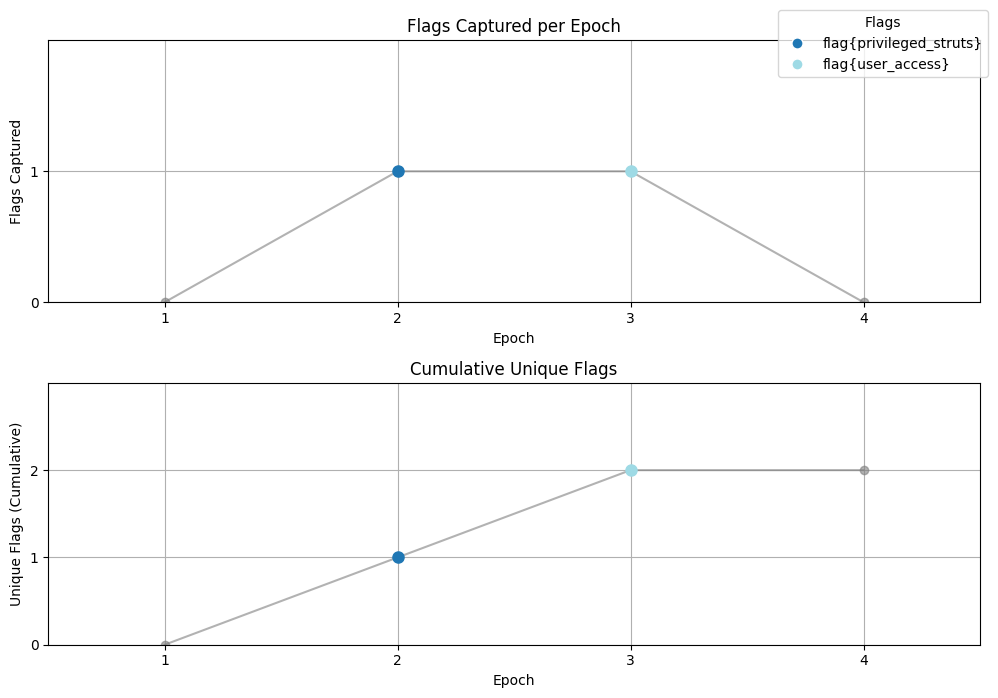

{'gitlab', 'activemq', 'struts', 'web'}
defaultdict(<class 'list'>, {'activemq': [33], 'gitlab': [66], 'struts': [100], 'web': [33]})
{'activemq': 33, 'gitlab': 66, 'struts': 100, 'web': 33}
defaultdict(<class 'int'>, {'struts': 1, 'gitlab': 1})
{'gitlab', 'activemq', 'struts'}
Groud truth: {'gitlab': 66, 'activemq': 33, 'struts': 100, 'web': 0}


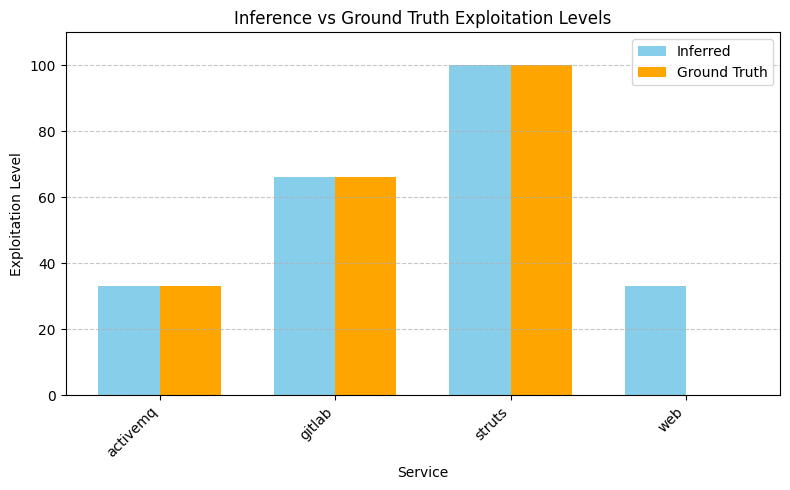

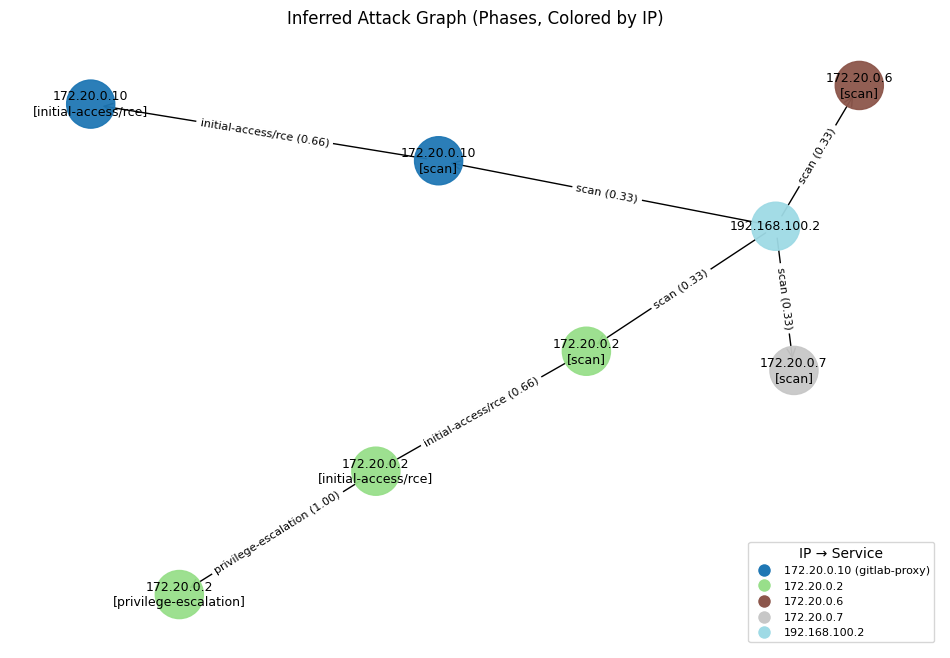

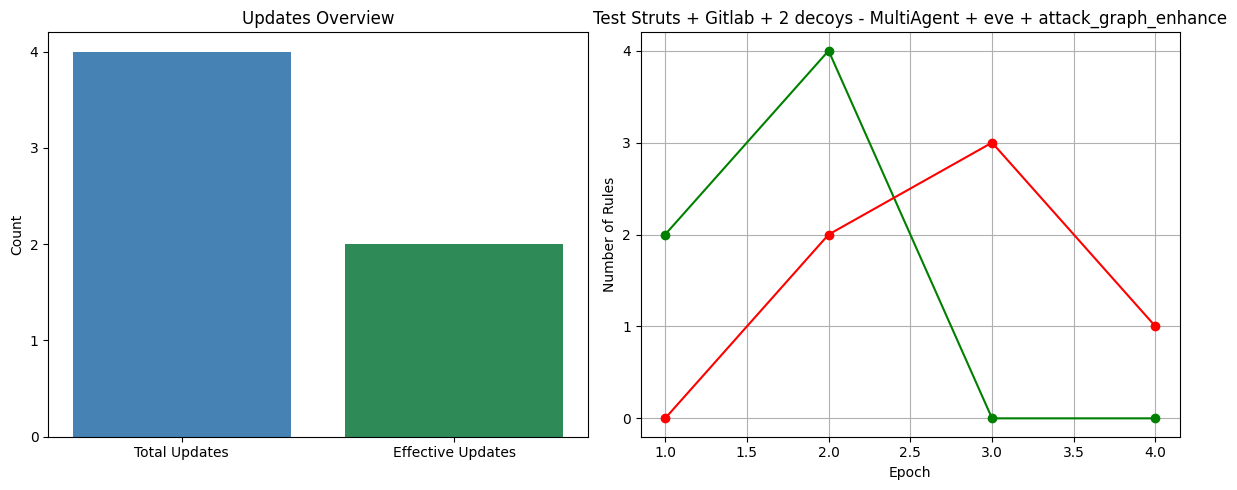

Analyzing Test Struts + Gitlab + 2 decoys - MultiAgent + fast + attack_graph_enhance with configuration: ['gitlab', 'struts', 'bash', 'activemq']
Loaded 5 epoch files
Flags Captured: ['flag{user_access}', 'flag{privileged_struts}']


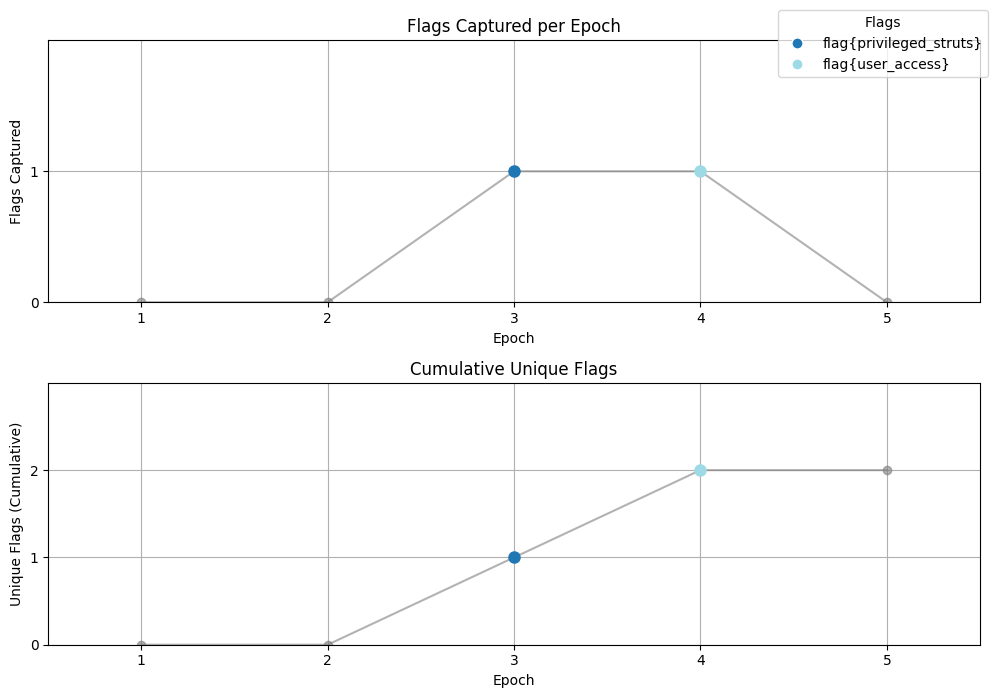

{'struts', 'gitlab', 'cve-2014-6271-web-1', 'cve-2015-5254-activemq-1'}
defaultdict(<class 'list'>, {'struts': [66], 'cve-2015-5254-activemq-1': [33], 'gitlab': [66], 'cve-2014-6271-web-1': [33]})
{'struts': 66, 'cve-2015-5254-activemq-1': 33, 'gitlab': 66, 'cve-2014-6271-web-1': 33}
defaultdict(<class 'int'>, {'struts': 1, 'gitlab': 1})
{'gitlab', 'cve-2015-5254-activemq-1', 'cve-2014-6271-web-1', 'struts'}
Groud truth: {'struts': 100, 'gitlab': 66, 'cve-2014-6271-web-1': 33, 'cve-2015-5254-activemq-1': 33}


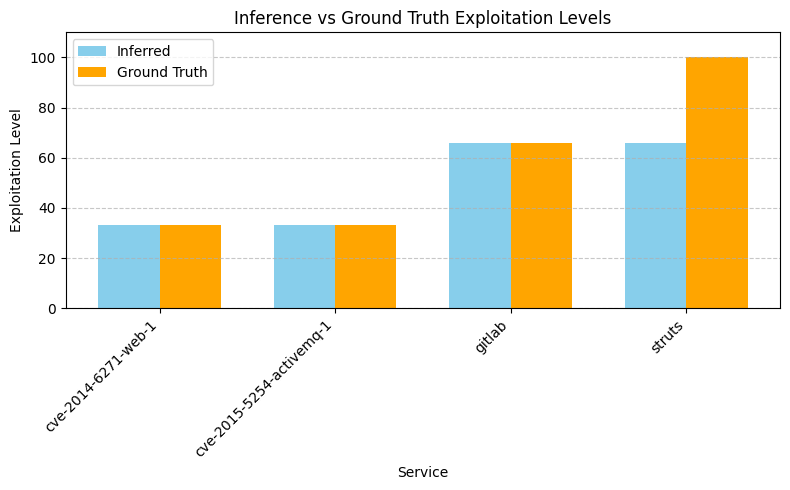

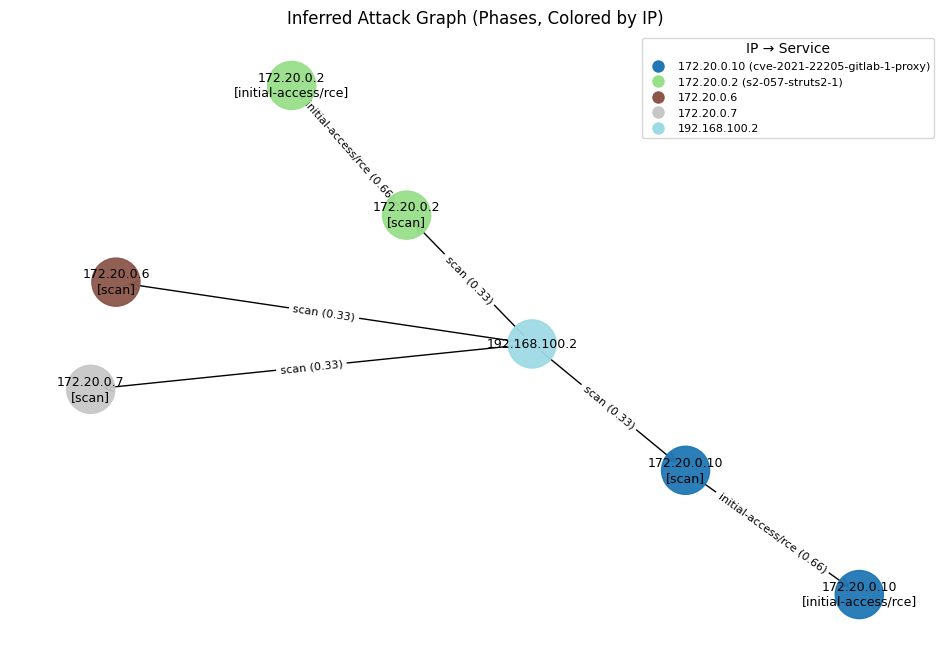

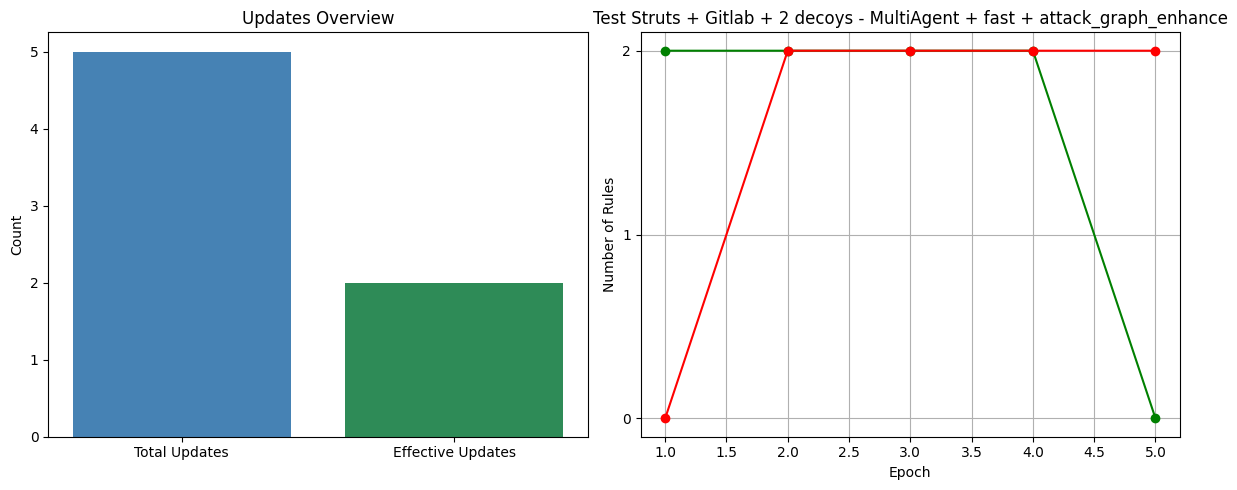

Analyzing All exploitable - MultiAgent + fast with configuration: ['gitlab', 'struts', 'php', 'docker']
Loaded 5 epoch files
Flags Captured: ['flag{rce_php}', 'flag{privileged_struts}', 'flag{privilege_escalation_php}', 'flag{user_access}', 'flag{docker}']


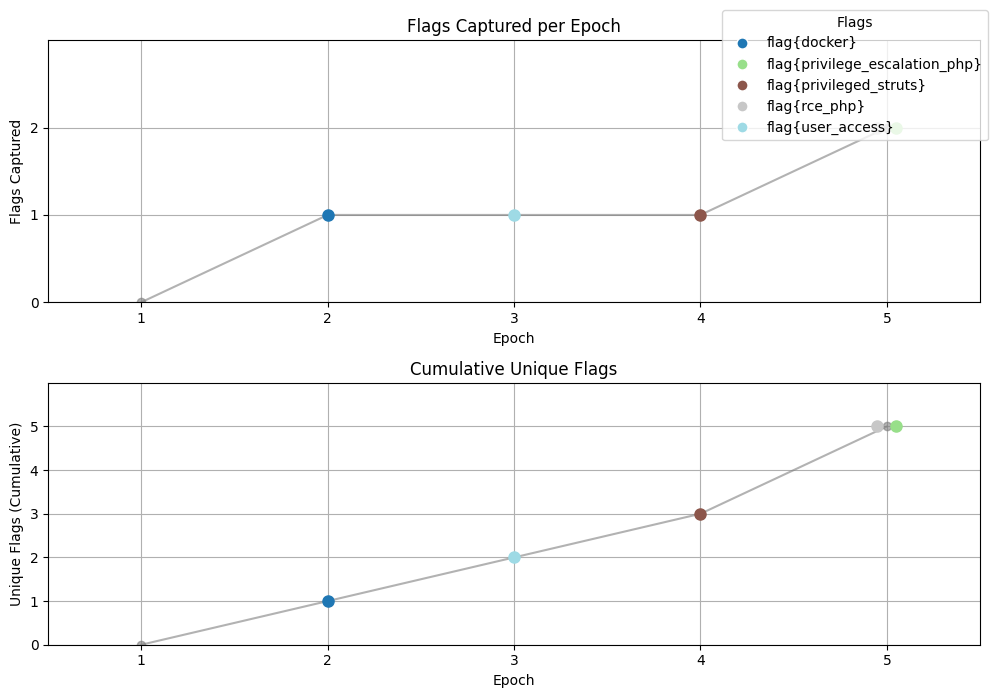

{'docker', 'gitlab', 'struts', 'php'}
defaultdict(<class 'list'>, {'gitlab': [66], 'struts': [66], 'docker': [66], 'php': [100]})
{'gitlab': 66, 'struts': 66, 'docker': 66, 'php': 100}
defaultdict(<class 'int'>, {'docker': 1, 'gitlab': 1, 'struts': 1, 'php': 2})
{'gitlab', 'php', 'docker', 'struts'}
Groud truth: {'docker': 100, 'gitlab': 66, 'struts': 100, 'php': 100}


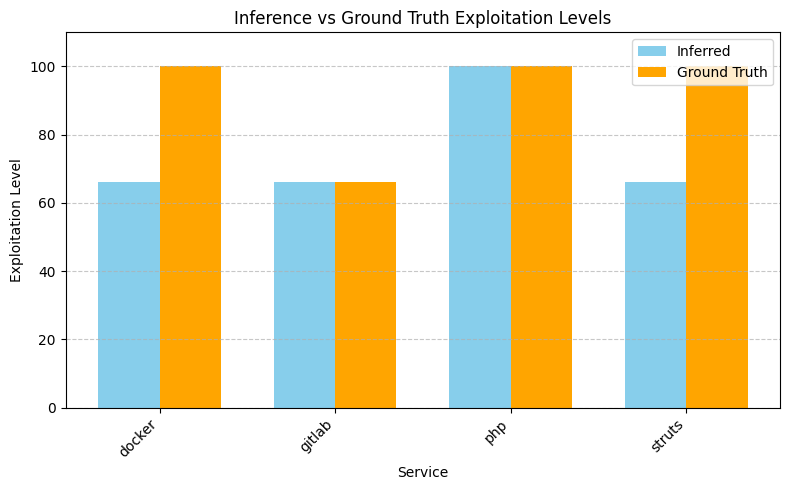

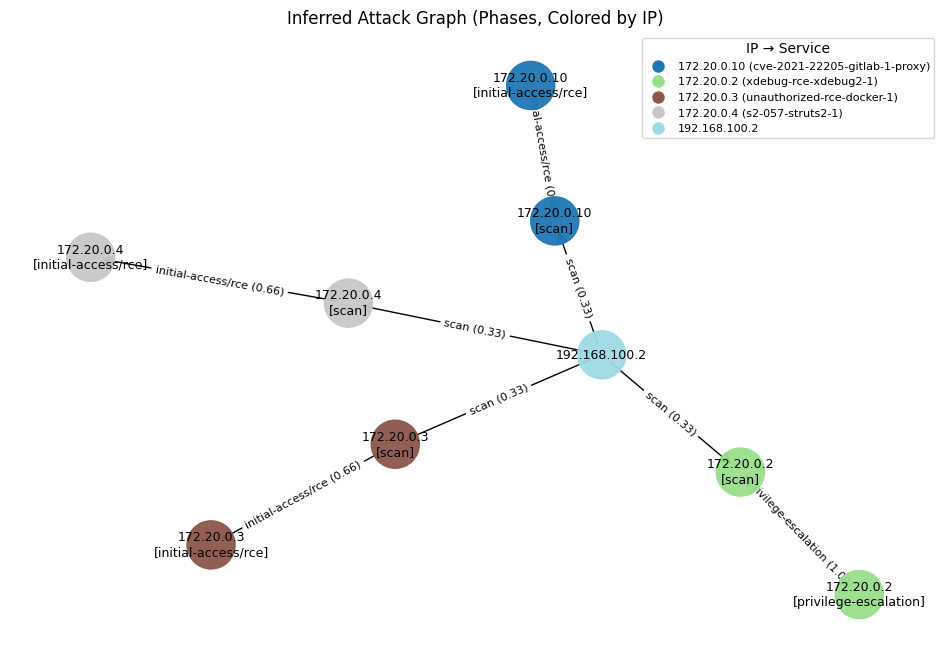

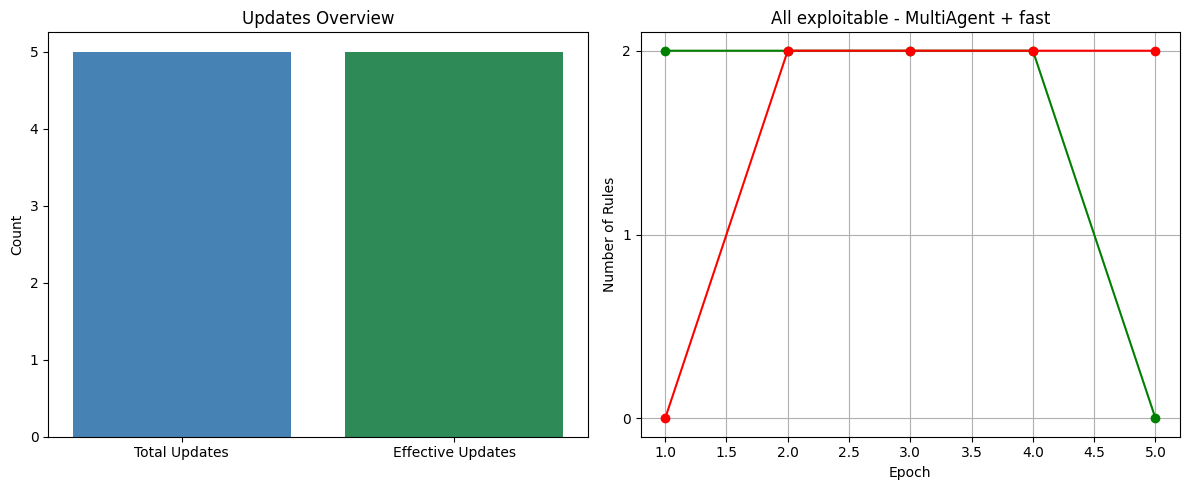

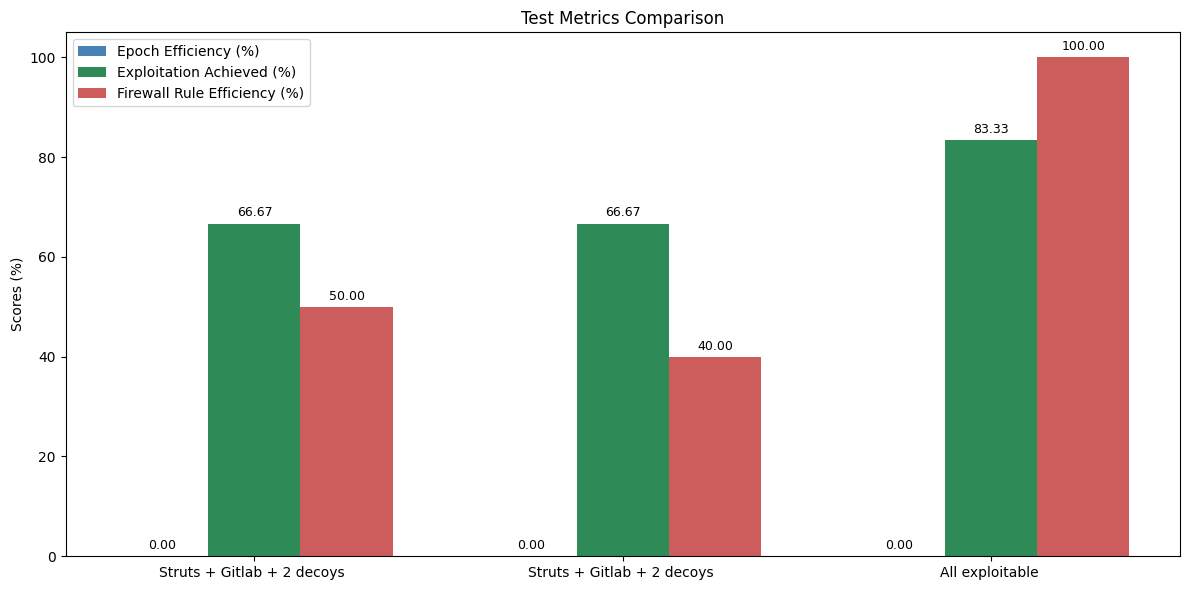

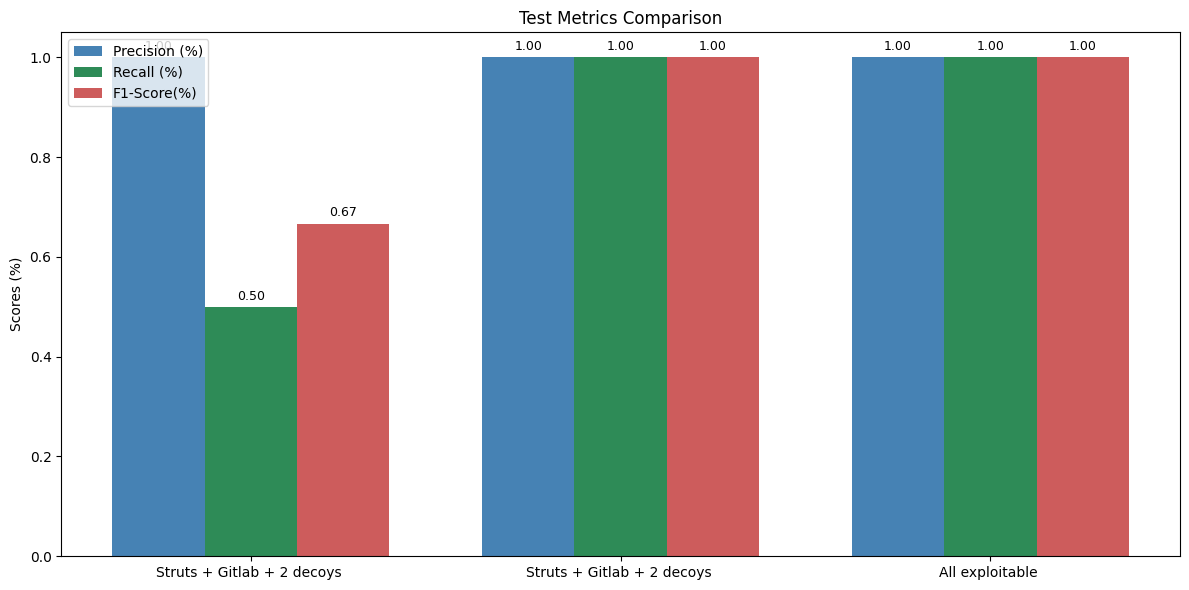

In [17]:
test_cases = ["Test Struts + Gitlab + 2 decoys - MultiAgent + eve + attack_graph_enhance", "Test Struts + Gitlab + 2 decoys - MultiAgent + fast + attack_graph_enhance", "All exploitable - MultiAgent + fast"]
configuration = [["gitlab", "struts", "bash", "activemq"], ["gitlab", "struts", "bash", "activemq"], ["gitlab", "struts", "php", "docker"]]
efficiencies = []
percentages = []
f_efficiencies = []
precision = []
recall = []
f1 = []
for path, config in zip(test_cases, configuration):
    print(f"Analyzing {path} with configuration: {config}")
    epochs = load_epoch_data(f"./{path}")
    
    efficiency, exp_perc = calculate_epoch_efficiency_score(epochs, config)
    fre = calculate_firewall_rule_efficiency(epochs, config)
    flags = compute_flags_per_epoch(epochs)
    plot_flags_evolution(flags)
    
    inference_results = compute_inference_exploitation_metric(epochs)
    plot_inference_exploitation(inference_results)
    plot_attack_graph(epochs[-1], title="Inferred Attack Graph (Phases, Colored by IP)")
    
    efficiencies.append(efficiency)
    percentages.append(exp_perc)
    f_efficiencies.append(fre['rule_efficiency'])
    
    result = attack_graph_inference(epochs, config)
    precision.append(result["precision"])
    recall.append(result["recall"])
    f1.append(result["f1"])
    
    plot_rule_updates(path, fre['total_updates'], fre['effective_updates'], fre['total_epochs'], fre['rules_by_epoch'])

plot_test_metrics(test_cases=test_cases, metric1=efficiencies, metric2=percentages, metric3=f_efficiencies)
plot_test_metrics(test_cases=test_cases, metric1=precision, metric2=recall, metric3=f1, use_case="inference")